# Chapter 3 - Exploratory Data Analysis

We will start out notebook by loading all datasets that might be useful for us.

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib.patches import Ellipse

In [3]:
csvs_path = [rf'datasets/{name}.csv' for name in ['hmeq', 'lgd', 'ratings', 'mortgage']]
hmeq, lgd, ratings, mortgage = list(map(pd.read_csv, csvs_path))

## One Dimensional Analysis

### Observed Frequencies and Empirical Distributions

The first thing we look at here when analising our data are the absolute and relative frequencies for the defaults in the morgage data set. But why look at the frequency? Well, frequency allow us to better understand which data values are common or uncommon in our dataset, it might be the first step in exploring our data

In [4]:
df = pd.crosstab(mortgage['default_time'], 'Frequency')
df.loc[:, 'Percent'] = df/len(mortgage)*100
df.loc[:, 'Cumulative Frequency'] = df['Frequency'].cumsum()
df.loc[:, 'Cumulative Percent'] = df['Percent'].cumsum()
df

col_0,Frequency,Percent,Cumulative Frequency,Cumulative Percent
default_time,,,,
0,607331,97.564937,607331,97.564937
1,15158,2.435063,622489,100.000000


Then, we will look at histograms, which plot the absolute (or relative) frequencies for values or classes of variables. They are good for showing general distributional features of dataset variables. You can see roughly where are the peaks of the distribution, it's shape (is it skewed or symmetric) and if there is any outliers.

We will also look at the cumulative distribution function (CDF) of the variable because it help us make decisions about the likelihood of the variable having a particular property, and is also useful to compare two variables.

In this example we will be using the FICO_orig_time. To plot our histogram we need to define the number of bins we want to use. You can choose it arbitrarily or use some kind of metric, in this case I'll be using Feedman-Diaconis rule where bin width is given by:

bin width = 2 * IQR(x) / n ^(-3)

Freedman–Diaconis number of bins: 182


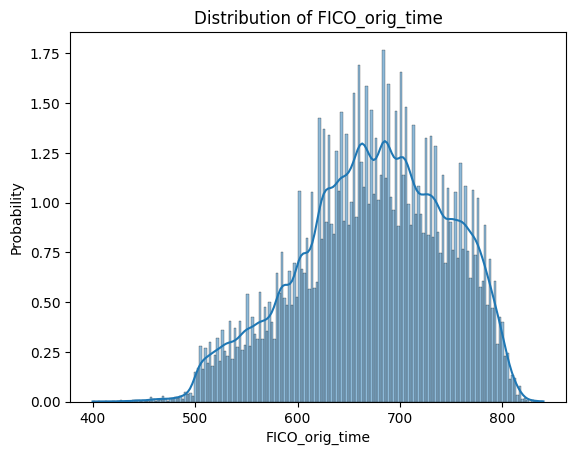

In [5]:
%matplotlib inline
x = mortgage['FICO_orig_time']
q25, q75 = np.percentile(x, [25, 75])
bin_width = 2 * (q75 - q25) * len(x) ** (-1/3)
bins = round((x.max() - x.min()) / bin_width)
print("Freedman–Diaconis number of bins:", bins)
sns.histplot(x, bins=bins, kde=True, stat = 'percent')
_ = plt.ylabel('Probability')
_ = plt.xlabel('FICO_orig_time')
_ = plt.title('Distribution of FICO_orig_time')

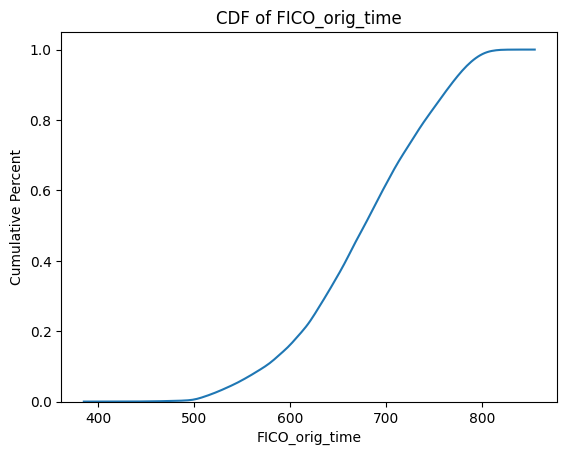

In [6]:
sns.kdeplot(data = x, cumulative = True)
_ = plt.ylabel('Cumulative Percent')
_ = plt.xlabel('FICO_orig_time')
_ = plt.title('CDF of FICO_orig_time')

Now let's do the same for the LTV, here we expect to see concentration in the region around 80%

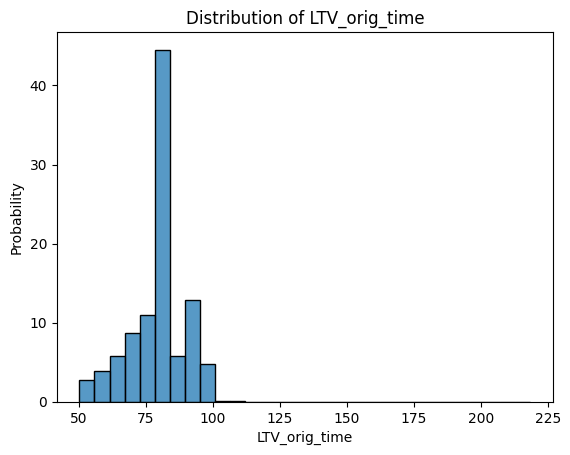

In [7]:
x = mortgage['LTV_orig_time']
sns.histplot(x, bins=30, kde=False, stat = 'percent')
_ = plt.ylabel('Probability')
_ = plt.xlabel('LTV_orig_time')
_ = plt.title('Distribution of LTV_orig_time')

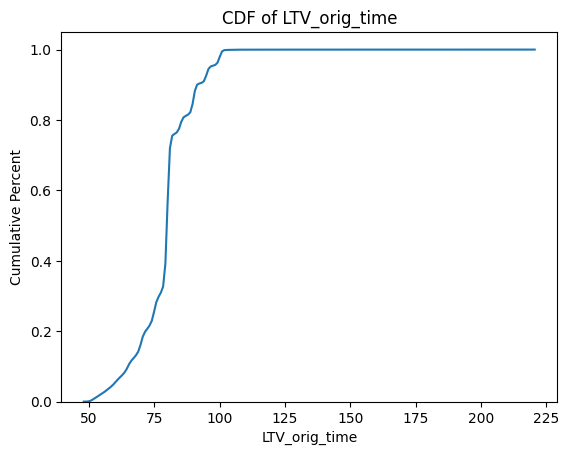

In [8]:
sns.kdeplot(data = x, cumulative = True)
_ = plt.ylabel('Cumulative Percent')
_ = plt.xlabel('LTV_orig_time')
_ = plt.title('CDF of LTV_orig_time')

### Location Measures

In addition or instead of the distribution in some cases, it's rather common to report some values that summarize our information. These values are called 'moments'. Some of the most common moments are the mean, variance, skewness and kurtosis. Here I'll be following the book and it's examples so we start with the mean, median and the mode. 

- The mean of a distribution is the arithmetic average of it's values (the equally weighted sum of each value of a variable summed over all observations)

- Median is defined as the middle point of an ordered list, it's the mean value of both observations in the middle of an ordered list.

- Mode is the observation most frequent in a data set

For most of the information in Exhibit 3.3 Location Measures we can use pd.describe(). Here I've added the mode to be the same as the exhibit. We can also see that as per definition the median is equal to the 50% percentile

In [9]:
# Let's take only the columns we want for the example
df = mortgage[['default_time', 'FICO_orig_time', 'LTV_orig_time']]
described = df.describe(include='all', percentiles=[.5, .01, 0.99])
mode_ = df.mode()
mode_.index = ['mode']
pd.concat([described, mode_], axis = 0)


,default_time,FICO_orig_time,LTV_orig_time
count,622489.000000,622489.000000,622489.000000
mean,0.024351,673.616922,78.975460
std,0.154135,71.724558,10.127052
min,0.000000,400.000000,50.100000
1%,0.000000,506.000000,52.200000
50%,0.000000,678.000000,80.000000
99%,1.000000,801.000000,100.000000
max,1.000000,840.000000,218.500000
mode,0.000000,660.000000,80.000000


With the information above we can see for example that the LTV has a mean value of 78.97% and a median of 80%, 1% of all values are lower or equal to 52.2% or higher or equal to 100%. with the lowest value being 50,1% and highest value being 218.5%, which imples the distribution is skewed to the left as observed in the histogram.

Quantiles can be used for a graphical comparison with standard distributions, such as a normal distribution.

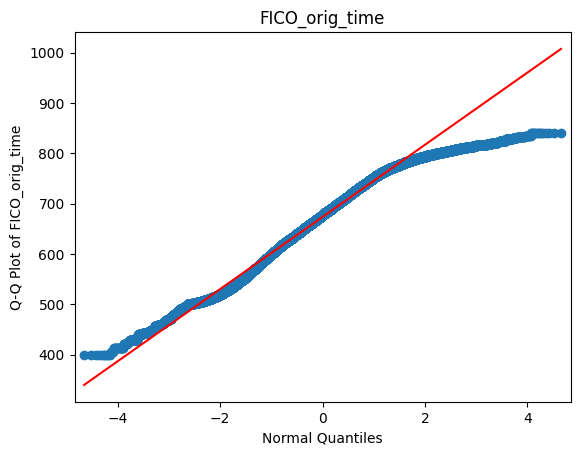

In [10]:
import statsmodels.api as sm 
from matplotlib import pyplot as plt

sm.qqplot(mortgage['FICO_orig_time'], line='s')
_ = plt.ylabel('Q-Q Plot of FICO_orig_time')
_ = plt.xlabel('Normal Quantiles')
_ = plt.title('FICO_orig_time')
plt.show()

### Dispersion Measures

Then, we start looking at dispersion measures:

- Span of range: The diference between the minimum and the maximum values.
- Mean Squared Error (MSE): Measures the average of the squares of the erros (average squared difference between the estimated values and the actual value).
- Sample variance:  Squared deviation quantifies how far an observation is from the mean. It's the average of the squared deviations (average distance -or spread- from the mean).
- Standard deviation: Measured how dispersed the data is in relation to the mean. The lower the value the more tightly clusted around the mean.

These metrics can be adjusted for samples (which in general changed the division from n to n-1). It's important to notice that these variables are scale dependent, that is, a variable with higher values in general should exhibit a higher dispersion, all else being equal.

Coefficient of variation tries to deal with this by normalizing the standard deviation by it's mean value.

In [11]:
def variables(df_, vnames):
    def single_variable(vname):
        variable_ = df_[vname]
        vn = len(variable_)
        vmin = variable_.min()
        vmax = variable_.max()
        vrange = vmax - vmin
        vquartile = variable_.quantile(0.25)
        vvar = variable_.var()
        vstd = variable_.std()
        vcoef = vstd / variable_.mean() *100
        dict_ = {'Variable': vname, 'N': vn, 'Minimum': vmin, 'Maximum': vmax, 'Range': vrange, 
                'Quartile Range': vquartile, 'Variance': vvar, 
                'Std Dev': vstd, 'Coeff of Variation': vcoef}
        return pd.DataFrame(dict_, index = [vnames.index(vname)])
    return pd.concat(list(map(single_variable, vnames)))

variables(mortgage, ['default_time', 'FICO_orig_time', 'LTV_orig_time'])

,Variable,N,Minimum,Maximum,Range,Quartile Range,Variance,Std Dev,Coeff of Variation
0,default_time,622489,0.0,1.0,1.0,0.0,0.023758,0.154135,632.983111
1,FICO_orig_time,622489,400.0,840.0,440.0,626.0,5144.412201,71.724558,10.647678
2,LTV_orig_time,622489,50.1,218.5,168.4,75.0,102.557183,10.127052,12.823037


### Skewness and Kurtosis Measures

Like the mean and the variance, the skewness and kurtosis are moments of the distribution, but that focuses on its shape.

- A negative value for the skewness shows that the distribution is skewed to the left while a positive values shows there is a skew to the right
- Usually we look at the excess kurtosis (in which case we subtract 3, because it's the normal's kurtosis) in which a negative values signals a lower kurtosis and a positive values signals a higher kurtosis than the normal distribution.

In [12]:
from scipy.stats import kurtosis, skew

def variables(df_, vnames):
    def single_variable(vname):
        variable_ = df_[vname]
        vn = len(variable_)
        kurt = kurtosis(variable_)
        skew_ = skew(variable_)
        dict_ = {'Variable': vname, 'N': vn, 'Skew': skew_,
                 'Excess Kurtosis': kurt}
        return pd.DataFrame(dict_, index = [vnames.index(vname)])
    return pd.concat(list(map(single_variable, vnames)))

variables(mortgage, ['default_time', 'FICO_orig_time', 'LTV_orig_time'])

,Variable,N,Skew,Excess Kurtosis
0,default_time,622489,6.171844,36.091656
1,FICO_orig_time,622489,-0.321290,-0.468435
2,LTV_orig_time,622489,-0.196438,1.436396


## Two Dimensional Analysis

### Joint Empirical Distributions

I've made my own implementation of some more complex SAS PROC below, but there are some more simple implementations you can easily find in the web, like https://daztech.com/proc-freq-equivalent-in-python/

In [13]:
mortgage['grouping'] = pd.qcut(mortgage['FICO_orig_time'], 5, labels=False)

In [14]:
mname = 'Total'
df = pd.crosstab(mortgage['grouping'], mortgage['default_time'], margins=True, margins_name=mname)
cols_ = [i for i in df.columns if i != mname]

In [15]:
dfs = [df.copy(), df.copy(), df.copy(), df.copy()]
names_ = ['1 - Quantity', '2 - Percentage Total', '3 - Percentage Non Defaults in Group', '4 - Group Percentages of Default']
for df_, name in zip(dfs, names_):
    df_.loc[:, 'Desc'] = name

for col_ in cols_:
    dfs[1].loc[:, col_] = df.loc[:, col_] / df.loc[mname, mname]
    dfs[2].loc[:, col_] = df.loc[:, col_] / df.loc[mname, col_]
    dfs[3].loc[:, col_] = df.loc[:, col_] / df.loc[:, mname]
df = pd.concat(dfs)


C:\Users\guilh\AppData\Local\Temp\ipykernel_31712\672805975.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.19472312 0.19229416 0.19951999 0.19446448 0.19464762 0.97564937]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs[1].loc[:, col_] = df.loc[:, col_] / df.loc[mname, mname]
C:\Users\guilh\AppData\Local\Temp\ipykernel_31712\672805975.py:8: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.19958309 0.19709351 0.20449969 0.199318   0.19950571 1.        ]' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  dfs[2].loc[:, col_] = df.loc[:, col_] / df.loc[mname, col_]
C:\Users\guilh\AppData\Local\Temp\ipykernel_31712\672805975.py:9: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0.96511776

In [16]:
df.reset_index(inplace = True)
df_ = pd.melt(df, id_vars=['grouping', 'Desc'])
df_ =df_[~((df_['Desc'] != '1 - Quantity') & (df_['default_time'] == mname))]
df_ = df_.pivot(index = ['default_time', 'Desc'], columns = 'grouping')
total_pct = df_.loc[mname, :].iloc[0, :] / df_.loc[mname,('value', mname)].iloc[0]
df_.loc[(mname, 'Pct'), :] = total_pct
df_

value  \
grouping                                                       0   
default_time Desc                                                  
0            1 - Quantity                          121213.000000   
             2 - Percentage Total                       0.194723   
             3 - Percentage Non Defaults in Group       0.199583   
             4 - Group Percentages of Default           0.965118   
1            1 - Quantity                            4381.000000   
             2 - Percentage Total                       0.007038   
             3 - Percentage Non Defaults in Group       0.289022   
             4 - Group Percentages of Default           0.034882   
Total        1 - Quantity                          125594.000000   
             Pct                                        0.201761   

                                                                  \
grouping                                                       1   
default_time Desc                                                  
0            1 - Quantity                          119701.000000   
             2 - Percentage Total                       0.192294   
             3 - Percentage Non Defaults in Group       0.197094   
             4 - Group Percentages of Default           0.969074   
1            1 - Quantity                            3820.000000   
             2 - Percentage Total                       0.006137   
             3 - Percentage Non Defaults in Group       0.252012   
             4 - Group Percentages of Default           0.030926   
Total        1 - Quantity                          123521.000000   
             Pct                                        0.198431   

                                                                  \
grouping                                                       2   
default_time Desc                                                  
0            1 - Quantity                          124199.000000   
             2 - Percentage Total                       0.199520   
             3 - Percentage Non Defaults in Group       0.204500   
             4 - Group Percentages of Default           0.974385   
1            1 - Quantity                            3265.000000   
             2 - Percentage Total                       0.005245   
             3 - Percentage Non Defaults in Group       0.215398   
             4 - Group Percentages of Default           0.025615   
Total        1 - Quantity                          127464.000000   
             Pct                                        0.204765   

                                                                  \
grouping                                                       3   
default_time Desc                                                  
0            1 - Quantity                          121052.000000   
             2 - Percentage Total                       0.194464   
             3 - Percentage Non Defaults in Group       0.199318   
             4 - Group Percentages of Default           0.980957   
1            1 - Quantity                            2350.000000   
             2 - Percentage Total                       0.003775   
             3 - Percentage Non Defaults in Group       0.155034   
             4 - Group Percentages of Default           0.019043   
Total        1 - Quantity                          123402.000000   
             Pct                                        0.198240   

                                                                  \
grouping                                                       4   
default_time Desc                                                  
0            1 - Quantity                          121166.000000   
             2 - Percentage Total                       0.194648   
             3 - Percentage Non Defaults in Group       0.199506   
             4 - Group Percentages of Default           0.989046   
1            1 - Quantity                  

From the table above, we can notice that as our FICO score increases, the group percentages of default in the above plot increases, the name is a bit counterintuitive as I've based in on default time = 1, but that means that as our FICO score increases, defaults start happening less often. We can also try looking at it via boxplots, as follows:

<Axes: xlabel='default_time', ylabel='FICO_orig_time'>

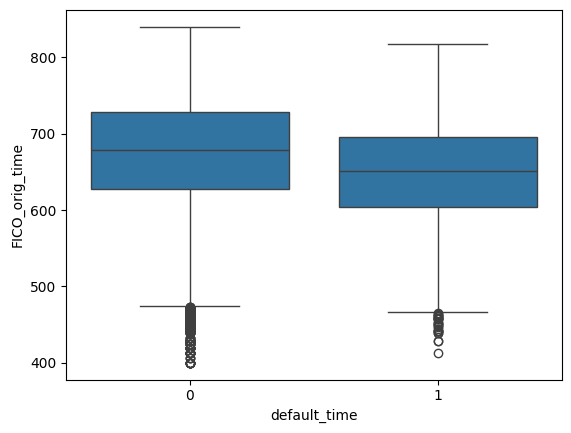

In [17]:
sns.boxplot(data=mortgage, y = 'FICO_orig_time', x = 'default_time')

<Axes: xlabel='default_time', ylabel='LTV_orig_time'>

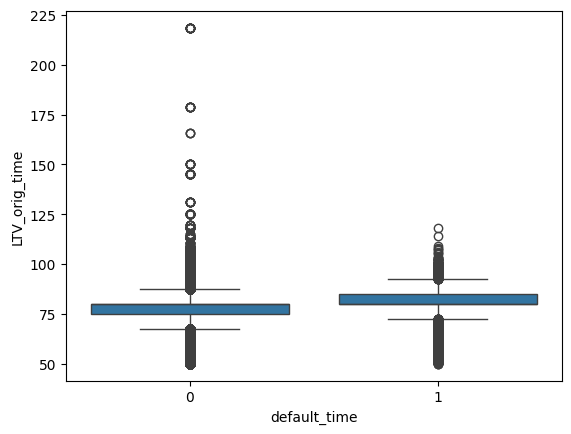

In [18]:
sns.boxplot(data=mortgage, y = 'LTV_orig_time', x = 'default_time')

From the box plots we can see that that a higher FICO score correspond to a lower default frequency and a higher LTV correspond to a higher default frequency. Which sounds logical, right? A client with a better credit score should be a better client and therefore default less and a credit which a Loan to Value too high may incentive not paying as the asset backing the credit has almost the value of the credit itself.

### Correlation Measures

As of this moment I couldn't find the implementations in python for every variable in the Procedure table. Cramer's V also doesn't return the same value. I'll have to look at this later and check how it's implemented on SAS.

In [19]:
# TODO: Check SAS Implementation for all variables calculations
from scipy.stats import chi2_contingency
cc_matrix = pd.crosstab(mortgage['default_time'], mortgage['FICO_orig_time'])
stat, p, dof, expected = chi2_contingency(cc_matrix,correction=True)

In [20]:
import scipy.stats as ss

def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2, p, dof, expected = ss.chi2_contingency(confusion_matrix)
    n = confusion_matrix.to_numpy().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

cramers_corrected_stat(cc_matrix)

np.float64(0.06088255719213436)

Now, looking at the correlation, things are easier because of pandas implementation:

In [21]:
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            tmp = df[df[r].notnull() & df[c].notnull()]
            pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)
    return pvalues

calculate_pvalues(mortgage[['FICO_orig_time', 'LTV_orig_time']])

C:\Users\guilh\AppData\Local\Temp\ipykernel_31712\791904831.py:10: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  pvalues[r][c] = round(pearsonr(tmp[r], tmp[c])[1], 4)


,FICO_orig_time,LTV_orig_time
FICO_orig_time,0.0,0.0
LTV_orig_time,0.0,0.0


In [22]:
np.random.seed(123456)
df = mortgage[['FICO_orig_time', 'LTV_orig_time']].sample(frac=0.01)
print ('Pearson Correlation coeficients')
print(df.corr(method='pearson', min_periods=1))

print('Spearman Correlation coefficients')
print(df.corr(method='spearman', min_periods=1))

print('Kendall Tau b Correlation Coefficients')
print(df.corr(method='kendall', min_periods=1))


Pearson Correlation coeficients
                FICO_orig_time  LTV_orig_time
FICO_orig_time        1.000000      -0.159198
LTV_orig_time        -0.159198       1.000000
Spearman Correlation coefficients
                FICO_orig_time  LTV_orig_time
FICO_orig_time        1.000000      -0.188072
LTV_orig_time        -0.188072       1.000000
Kendall Tau b Correlation Coefficients
                FICO_orig_time  LTV_orig_time
FICO_orig_time        1.000000      -0.136148
LTV_orig_time        -0.136148       1.000000


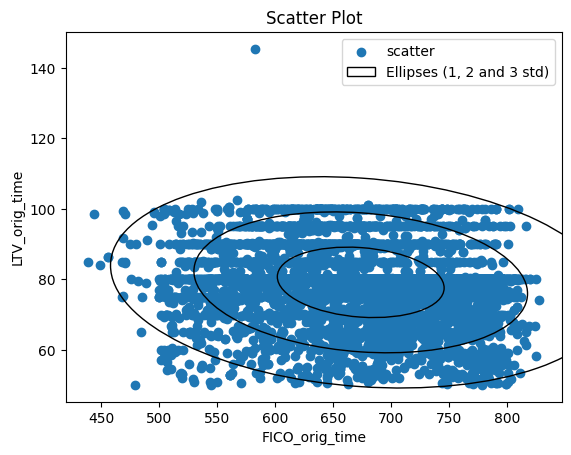

In [23]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:,order]

y = df['LTV_orig_time']
x = df['FICO_orig_time']

nstds = [1, 2, 3]
ax = plt.subplot(111)

cov = np.cov(x, y)
vals, vecs = eigsorted(cov)
theta = np.degrees(np.arctan2(*vecs[:,0][::-1]))
plt.scatter(x, y)
for nstd in nstds:
    w, h = 2 * nstd * np.sqrt(vals)
    ell = Ellipse(xy=(np.mean(x), np.mean(y)),
                width=w, height=h,
                angle=theta, color='black')
    ell.set_facecolor('none')
    ax.add_artist(ell)

_ = plt.ylabel('LTV_orig_time')
_ = plt.xlabel('FICO_orig_time')
_ = plt.title('Scatter Plot')
_ = plt.legend(["scatter", "Ellipses (1, 2 and 3 std)"], loc="upper right")
plt.show()

### Highlights of Inductive Statistics

In [24]:
import statsmodels.stats.api as sms

a = mortgage['LTV_orig_time']
a_desc = sms.DescrStatsW(a)
tstat_mean = a_desc.tconfint_mean(alpha=0.01)
std_mean = a_desc.std_mean

pd.DataFrame({'Estimate': [a_desc.mean, a_desc.std, a_desc.var], 
              'Lower CF':[tstat_mean[0], None, None], 
              'Upper CF':[tstat_mean[1], None, None]}, 
              index = ['Mean', 'Std Dev', 'Variance'])



,Estimate,Lower CF,Upper CF
Mean,78.975460,78.942397,79.008522
Std Dev,10.127044,NaN,NaN
Variance,102.557019,NaN,NaN


In [25]:
from scipy import stats
import statsmodels.stats.descriptivestats as smd
mu = 60
t_stat, p_value = stats.ttest_1samp(a, mu)
m_stat, m_value = smd.sign_test(a, mu0=mu)
pd.DataFrame({'Statistic': [t_stat, m_stat], 'p-value': [p_value, m_value]},
             index = ['Students t', 'Sign'])

,Statistic,p-value
Students t,1478.342638,0.0
Sign,277123.000000,0.0
